In [1]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from knn import CudaKNN
from utils import load_data, pca_cudaknn_grid_search

%reload_ext autoreload
%autoreload 2

# Load data

In [2]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data(test_size=10000,
                                                           validation_size=7000,
                                                           flatten=True,
                                                           dataset='mnist')

# Principal components analysis

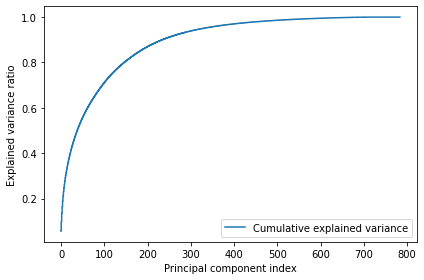

In [3]:
scaler = StandardScaler()
X_train_std = torch.from_numpy(scaler.fit_transform(X_train))
X_val_std = torch.from_numpy(scaler.transform(X_val))
X_test_std = torch.from_numpy(scaler.transform(X_test))

pca = PCA()
pca.fit(X_train_std)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# PCA + CudaKNN grid search

In [4]:
batch_sizes = [120, 96, 64, 52, 40, 32, 24, 16]
ns_components = [30, 50, 100, 200, 300, 400, 500, 600]
ns_neighbors = np.arange(1, 11, 1)
p = 2
cuda = True

In [5]:
errors, Y_pred, times = pca_cudaknn_grid_search(
    X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val,
    ns_components=ns_components, ns_neighbors=ns_neighbors,
    batch_size=batch_sizes, p=p, cuda=cuda, verbose=True
)

[PCA n=30]
[k-NN k=1] (7000/7000) error rate = 3.3857%
[k-NN k=1] error rate = 3.3857%
[k-NN k=2] (7000/7000) error rate = 4.0000%
[k-NN k=2] error rate = 4.0000%
[k-NN k=3] (7000/7000) error rate = 3.4286%
[k-NN k=3] error rate = 3.4286%
[k-NN k=4] (7000/7000) error rate = 3.4857%
[k-NN k=4] error rate = 3.4857%
[k-NN k=5] (7000/7000) error rate = 3.4143%
[k-NN k=5] error rate = 3.4143%
[k-NN k=6] (7000/7000) error rate = 3.4571%
[k-NN k=6] error rate = 3.4571%
[k-NN k=7] (7000/7000) error rate = 3.4571%
[k-NN k=7] error rate = 3.4571%
[k-NN k=8] (7000/7000) error rate = 3.4286%
[k-NN k=8] error rate = 3.4286%
[k-NN k=9] (7000/7000) error rate = 3.5714%
[k-NN k=9] error rate = 3.5714%
[k-NN k=10] (7000/7000) error rate = 3.5571%
[k-NN k=10] error rate = 3.5571%

[PCA n=50]
[k-NN k=1] (7000/7000) error rate = 3.0000%
[k-NN k=1] error rate = 3.0000%
[k-NN k=2] (7000/7000) error rate = 3.5714%
[k-NN k=2] error rate = 3.5714%
[k-NN k=3] (7000/7000) error rate = 2.8143%
[k-NN k=3] error ra

In [6]:
conf_matrix = {
    n: {
        k: confusion_matrix(
            Y_val[:Y_pred[n][k].shape[0]], 
            Y_pred[n][k]
        ) for k in ns_neighbors
    } for n in ns_components
}

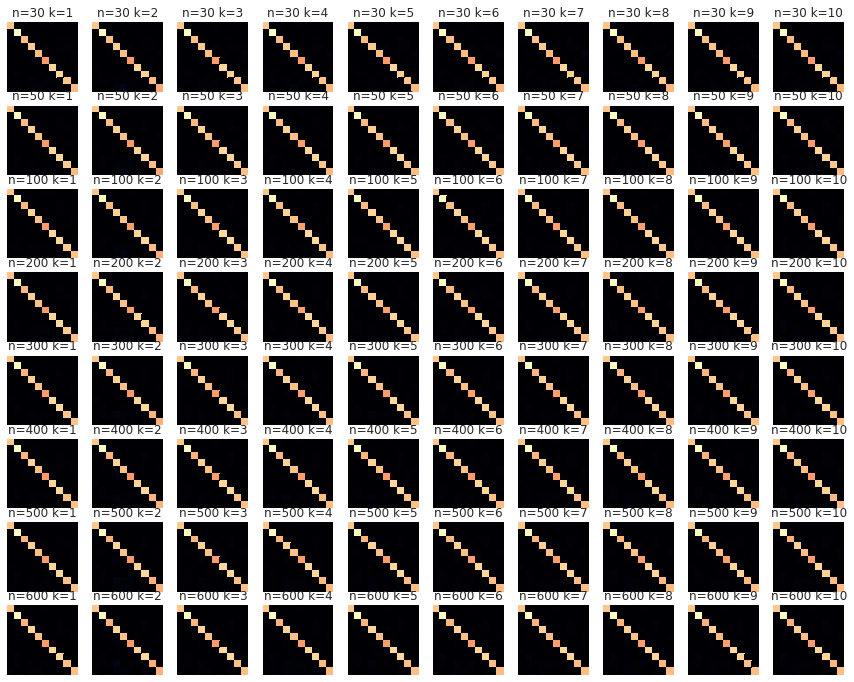

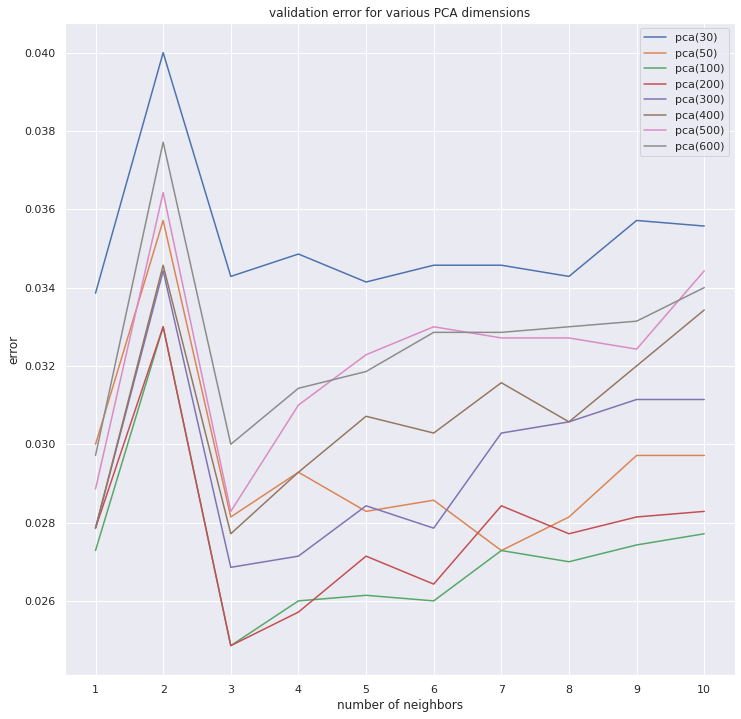

In [7]:
sns.set(rc={'figure.figsize':(len(ns_neighbors)*1.5, len(ns_components)*1.5)})
f, axs = plt.subplots(nrows=len(ns_components), ncols=len(ns_neighbors))
for i, n in enumerate(ns_components):
    for j, k in enumerate(ns_neighbors):
        axs[i][j].axis('off')
        axs[i][j].set_title(f'n={n} k={k}')
        sns.heatmap(conf_matrix[n][k], ax=axs[i][j], cmap='magma', cbar=False)
plt.show()

sns.set(rc={'figure.figsize':(len(ns_components)*1.5, len(ns_components)*1.5)})
for n in ns_components:
    plt.plot(ns_neighbors, errors[n], label=f'pca({n})')
    plt.xticks(ns_neighbors)
plt.xlabel('number of neighbors')
plt.ylabel('error')
plt.legend()
plt.title('validation error for various PCA dimensions')
plt.show()